In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The Gaussian-Mixture-Model and the Expectation-Maximation Algorithm

In [3]:
import numpy as np
import pandas as pd
from numpy.linalg import slogdet, inv

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 150

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get Data

Use mouse dataset: https://github.com/elki-project/elki/blob/master/data/synthetic/Vorlesung/mouse.csv

In [ ]:
########################################################
## Number of clusters: 4
########################################################
## Cluster: Head
########################################################
## Size: 290
## Clipping: [0.00000000 0.00000000] - [1.00000000 1.00000000]
## Density correction factor: 1.0
## Generators:
##   Normal Distribution (mean=0.5, stddev=0.2)
##   Normal Distribution (mean=0.5, stddev=0.2)
## Discards: 203 Retries left: 986
## Density correction factor estimation: 1.1789181692094313
########################################################
## Cluster: Ear_left
########################################################
## Size: 100
## Clipping: [0.00000000 0.00000000] - [1.00000000 1.00000000]
## Density correction factor: 1.0
## Generators:
##   Normal Distribution (mean=0.25, stddev=0.05)
##   Normal Distribution (mean=0.75, stddev=0.05)
## Discards: 8 Retries left: 1000
## Density correction factor estimation: 0.7489597780859918
########################################################
## Cluster: Ear_right
########################################################
## Size: 100
## Clipping: [0.00000000 0.00000000] - [1.00000000 1.00000000]
## Density correction factor: 1.0
## Generators:
##   Normal Distribution (mean=0.75, stddev=0.05)
##   Normal Distribution (mean=0.75, stddev=0.05)
## Discards: 7 Retries left: 1000
## Density correction factor estimation: 0.7420249653259363
########################################################
## Cluster: Noise
########################################################
## Size: 10
## Density correction factor: 50.0
## Generators:
##   Uniform Distribution (min=0.0, max=1.0)
##   Uniform Distribution (min=0.0, max=1.0)
## Discards: 3 Retries left: 1000
## Density correction factor estimation: 0.9015256588072122
########################################################

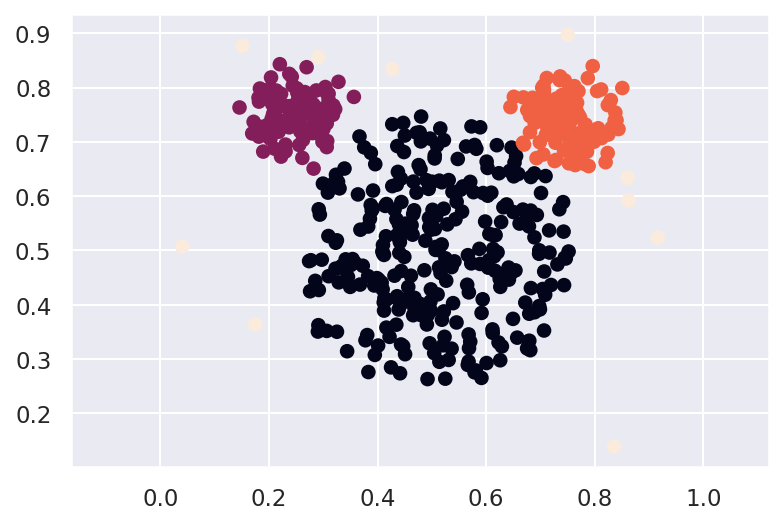

In [14]:
X = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/bayesian_methods/data/mouse.txt', delimiter=", ")
df = pd.DataFrame({'X': data[:,0], 'Y': data[:,1], 'class': data[:,2]})
plt.scatter(x=df["X"], y=df["Y"], c=df["class"])
plt.axis('equal')
plt.show()

# Expectation Maximation Algorithm

In [5]:
def get_Y(X, mu, sigma, pi):
  """
  Arguments:
  X: (N, d) -- dataset
  mu: (C, d) -- cluster means
  sigma: (C, d, d) -- cluster covariance matrices
  pi: (C, 1) -- cluster weights

  Returns:
  Y: (N, C) -- use for vlb or as argument in E_step
  """
  N, d = X.shape
  C = mu.shape[0]

  Y = np.zeros((N,C))
  
  for c in range(C):
    X_prime = X - mu[c]
    sig_inv = inv(sigma[c])
    for n in range(N):
      x_prime = X_prime[n]
      y = np.dot(sig_inv, x_prime)

      # Gaussian & exponentiated factor
      arg = np.dot(x_prime, y)
      arg += d * np.log(2 * np.pi)
      arg += slogdet(sigma[c])[1]
      arg *= -0.5
      # Exponentiated pi
      arg += np.log(pi[c])
      Y[n, c] = arg
  
  return Y

In [9]:
def initialize(C, d):
  """
  Arguments:
  C -- number of clusters
  d -- dimension of a single data point
  
  Returns:
  pi: (C, 1) -- cluster weights
  mu: (C, d) -- cluster means
  sigma: (C, d, d) -- cluster covariance matrices
  """
  # sum(pi) == 1
  pi = np.random.rand(C, 1)
  pi /= np.sum(pi, axis=0)

  mu = np.random.rand(C, d)

  sigma = np.zeros((C, d, d))
  for c in range(C):
    A = np.random.rand(d, d)
    sigma[c, :, :] = np.dot(A, A.T)
            
  return pi, mu, sigma
          
def convergence(loss, loss_prev, rtol):
  """
  Arguments:
  loss -- new loss
  loss_prev -- previous loss
  rtol -- 

  Returns:
  conv -- boolean indicating convergence
  
  """
  increase = np.abs((loss - loss_prev)/loss_prev)
  conv = increase <= rtol

  return increase, conv

In [6]:
def E_step(X, mu, sigma, pi):
  """
  Arguments:
  X: (N, d) -- dataset
  mu: (C, d) -- cluster means
  sigma: (C, d, d) -- cluster covariance matrices
  pi: (C, 1) -- cluster weights

  Returns:
  gamma: (N, C) -- posterior probabilities for each cluster and datapoint
  """
  N, d = X.shape
  C = pi.shape[0]

  gamma = np.zeros((N, C))
  pi = np.reshape(pi, (C, 1))

  Y = get_Y(X, mu, sigma, pi)
  max_Y = np.max(Y, axis=1, keepdims=True)

  Y_prime = Y - max_Y

  gamma = np.exp(Y_prime)
  gamma /= np.sum(gamma, axis=1, keepdims=True)

  return gamma

In [7]:
def M_step(X, gamma):
  """
  Arguments:
  X: (N, d) -- dataset
  gamma: (N, C) -- posterior probabilities for each cluster and datapoint

  Returns:
  mu: (C, d) -- cluster means
  sigma: (C, d, d) -- cluster covariance matrices
  pi: (C, 1) -- cluster weights
  """
  N, d = X.shape
  C = gamma.shape[1]
    
  pi = np.zeros((C, 1))
  mu = np.zeros((C, d))
  sigma = np.zeros((C, d, d))

  # Calculate cluster weights -- pi
  gamma_sum = np.sum(gamma, axis=0)
  pi = gamma_sum / N

  # Calculate gaussian parameters -- mu, sigma
  for c in range(C):
    gammac = np.reshape(gamma[:,c], (N,1))
    # Calculate mu
    mu[c] = np.sum(X*gammac, axis=0, keepdims=True)/gamma_sum[c]
    # Calculate sigma
    num = 0
    for n in range(N):
      x_prime = X[n] - mu[c]
      num += gammac[n]*np.outer(x_prime, x_prime)
    sigma[c] = num/gamma_sum[c]

  return pi, mu, sigma

In [8]:
def compute_vlb(X, mu, sigma, pi, gamma):
  """
  Arguments:
  X: (N, d) -- dataset
  mu: (C, d) -- cluster means
  sigma: (C, d, d) -- cluster covariance matrices
  pi: (C, 1) -- cluster weights
  gamma: (N, C) -- posterior probabilities for each cluster and datapoint

  Returns:
  loss -- variational lower bown
  """
  N, d = X.shape
  C = pi.shape[0]

  Y = get_Y(X, mu, sigma, pi)
  loss = np.sum(np.sum(gamma*(Y - np.log(gamma))))

  return loss

In [22]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Arguments:
    X: (N, d) -- dataset
    C -- number of cluster components
    rtol -- stopping treshold
    max_iter -- maximum iteration
    restarts -- number of EM restarts with new randomly initialized parameters
    
    Returns:
    best_loss -- highest vlb 
    best_pi -- pi for highest vlb
    best_mu -- mu for highest vlb
    best_sigma -- sigma for highest vlb
    '''
    N, d = X.shape
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
          pi, mu, sigma = initialize(C, d)
          for _ in range(max_iter):
            gamma = E_step(X, mu, sigma, pi)
            loss_prev = compute_vlb(X, mu, sigma, pi, gamma)
            pi, mu, sigma = M_step(X, gamma)
            loss = compute_vlb(X, mu, sigma, pi, gamma)

            _, conv = convergence(loss, loss_prev, rtol)
            if conv:
              break

          if best_loss == None or loss > best_loss:
            best_loss = loss
            best_pi = pi
            best_mu = mu
            best_sigma = sigma
            print("Loss = " + str(best_loss))
            
          print("Restart...")

        except np.linalg.LinAlgError:
            print("Singular Matrix")
            print("Restart...")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [23]:
X = data[:,0:2]
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)

Loss = 607.6440826562825
Restart...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


Loss = 608.3006896243925
Restart...
Restart...
Restart...
Restart...
Restart...
Restart...
Restart...
Restart...
Restart...


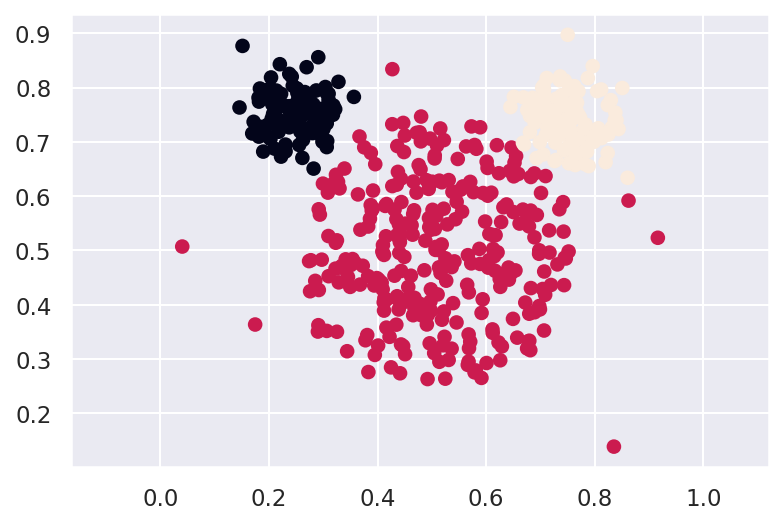

In [24]:
gamma = E_step(X, best_mu, best_sigma, best_pi)
labels = gamma.argmax(axis=1)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.axis('equal')
plt.show()